In [125]:
import itertools
import math

import numpy as np
import seaborn as sns
from tqdm import tqdm
from scipy.stats import poisson

# Parameters

In [221]:
initial_cases = 10

# sweep over [0.0 - 1.0]  # based on travel rates
imported_cases_per_step = .5  # really, there's a cost to setting this too, if we make it part of the action space

# .97 - .98
# .97 ** (6*30 / 4) == 0.25
# .98 ** (6*30 / 4) == 0.4
#   --> credence assigned to NO vaccine in 6 months
#        strikes balance of giving a fair chance of 6 month vaccine; while not giving high chance to vaccine in 2-months
discount = 0.99

# time step: ~4 days  (1 generation period)
num_population = 1000

In [222]:
# is this really a fair form? 
# wouldn't keeping everyone home for 6 weeks have some finite cost?

# Cost of setting R
R_0 = 2.5   # 2.8? #3?  look up; depends on the place

# sweep:  [1, 3]
power = 2

# average person's annual economic contribution: $50,000?
economic_contribution_annual = 50000
economic_contribution_2_weeks = economic_contribution_annual * 2.0 / 52
cost_to_keep_half_home = num_population / 2 * economic_contribution_2_weeks

# want: cost_of_r(R_0 / 4) == cost_to_keep_half_home
# Better: how much economic loss has the US had, to keep R ~= 1
# (1/((R_0/4)**power) - 1/(R_0 ** power)) * scale_factor == cost_to_keep_half_home
# scale_factor = cost_to_keep_half_home / (1/((R_0/4)**power) - 1/(R_0 ** power))

# population of 100,000:
# R = 1 for 4 days  ~=  100 people getting sick (25 ppl / day * 4 days)
# every 20 days: 500 people sick -> 5 person dead

# cost_of_r(1.0) == cost_of_n(100) == cost of 1 death + other bad effects ?= $4,000,000
# [1/(1 ** power) - 1/(R_0 ** power)] * scale_factor == 100
# scale_factor = 100 / [1 - 1/(R_0 ** power)]


def cost_of_r(r, power=power):
    baseline = 1/(R_0 ** power)
    actual = 1/(r ** power)
    
    scale_factor = 100 # cost_to_keep_half_home / (1/((num_population/4)**power) - 1/(R_0 ** power))
    
    if r >= R_0:
        return 0
    else:
        return (actual - baseline) * scale_factor

6

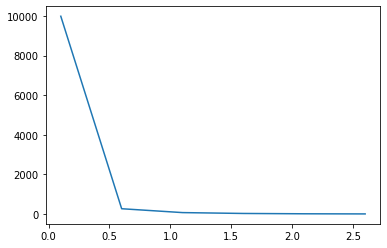

In [223]:
rs = np.arange(0.1, 3.1, 0.5)
costs_of_r = [cost_of_r(r) for r in rs]
sns.lineplot(x=rs, y=costs_of_r)
actions = rs
num_actions = len(actions)
num_actions

In [224]:
cost_of_r(1.0) / cost_of_r(0.5)

0.21875

In [225]:
# Cost of N (number of cases)
# assume cost of someone getting sick is $40,000

'''fraction_need_hospital = 0.04
cost_per_hospital_visit = 50000
cost_per_death = 1e6

# cost_of_n(n) == n
# cost_of_r(1.0) == cost_of_n(100) == 100

hospital_capacity = 25 # 5% of population #  20000

death_rate_hospital = 0.25
death_rate_neglected = 0.9'''


def cost_of_n(n):
    if n <= 0:
        return 0
    else:
        return n
    
    '''    num_need_hospital = n * fraction_need_hospital
        num_hospital = min(num_need_hospital, hospital_capacity)
        num_neglected = num_need_hospital - num_hospital
        num_deaths = num_neglected * death_rate_neglected + num_hospital * death_rate_hospital
        
        return cost_per_hospital_visit * num_hospital + cost_per_death * num_deaths '''

297

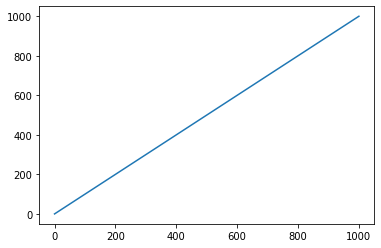

In [229]:
ns = sum([list(range(100*i, 100*(i+1), i+1)) for i in range(10)], []) + \
     [1_000]
     #sum([list(range(1000*i, 1000*(i+1), (i+1)*10)) for i in range(1, 10)], []) + \
     #sum([list(range(10000*i, 10000*(i+1), (i+1)*100)) for i in range(1, 10)], []) + \
     
# #list(range(num_population))
costs_of_n = [cost_of_n(n) for n in ns]
sns.lineplot(x=ns, y=costs_of_n)
states = ns
num_states = len(states)
num_states

In [230]:
lookup = dict([(x, i) for i in range(num_states - 1) for x in range(states[i], states[i+1])] + [(num_population, len(states) - 1)])
def bucket_state_index(new_state):
    if new_state < 0:
        raise Exception('Cannot have negative case count')
    elif new_state in lookup:
        return lookup[new_state]
    else:
        return lookup[num_population]
list(lookup.items())[-10:]

[(991, 295),
 (992, 295),
 (993, 295),
 (994, 295),
 (995, 295),
 (996, 295),
 (997, 295),
 (998, 295),
 (999, 295),
 (1000, 296)]

In [231]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [232]:
find_nearest(states, 2329)

1000

In [233]:
def expected_new_state(current_state, action):
    r_effective = action
    current_cases = current_state
    
    fraction_susceptible = 1 # (num_population - current_cases) / num_population
    # TODO: may need better way to bound susceptible population,
    # to account for immunity
    # One option: fraction_susceptible = 1 always, and just bound new_state by num_population

    # Better solution: keep track of how many people are susceptible NOW, based on some immunity time
    expected_new_cases = (current_cases * r_effective + imported_cases_per_step) * fraction_susceptible

    return expected_new_cases

In [234]:
expected_new_state(2330, 2.0)

4660.5

In [235]:
def new_state_distribution(state, action):
    lam = expected_new_state(state, action)
    # TODO: change to negative binomial; look up constant in literature for COVID
    return poisson(lam)

In [236]:
distribution = new_state_distribution(2330, 2.0)
distribution.mean(), distribution.var(), distribution.median()

(4660.5, 4660.5, 4660.0)

In [237]:
distribution.cdf(4750) - distribution.cdf(4700)

0.18443092046258014

In [238]:
def bucketed_distribution(distribution, states):
    probs = np.zeros_like(states, dtype=float)
    for state_idx in range(num_states - 1):
        low_state = states[state_idx]
        high_state = states[state_idx + 1]
        probs[state_idx] = (distribution.cdf(high_state) - distribution.cdf(low_state))
    probs[num_states - 1] = 1 - distribution.cdf(states[num_states - 1])
    return probs

In [239]:
bucket_distr = bucketed_distribution(distribution, states)
[bucket_distr[bucket_state_index(x)] for x in [4500, 4550, 4600, 4650, 4700, 4750, 4800]]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [240]:
transition_probabilities = np.zeros((num_states, num_actions, num_states))
transition_probabilities.shape

(297, 6, 297)

In [242]:
for state_idx in tqdm(range(num_states)):
    for action_idx in range(num_actions):
        distribution = new_state_distribution(states[state_idx], actions[action_idx])
        bucket_distr = bucketed_distribution(distribution, states)
        transition_probabilities[state_idx, action_idx] = bucket_distr
        #print(len(bucket_distr))

100%|██████████| 297/297 [02:05<00:00,  2.37it/s]


In [243]:
def reward(state, action):
    n = state
    r_effective = action
    return -cost_of_n(n) - cost_of_r(r_effective)  # should this be cost_of_n(new_state)?

In [244]:
def step(state_idx, action_idx):
    # state: number of current cases (discretized)
    # action: value of R_effective to set (discretized)
    # return: new_state, reward
    
    distr = new_state_distribution(states[state_idx], actions[action_idx])
    new_state = distr.rvs()
    
    # TODO: change to an actual expectation
    # ensure number of infected people does not exceed entire population
    new_state = min(new_state, num_population)
    new_state_idx = bucket_state_index(new_state)  # discretized case count
    
    resulting_reward = reward(states[state_idx], actions[action_idx])
    
    return new_state_idx, resulting_reward

In [245]:
state_idx = bucket_state_index(322)
print(f'original state: {states[state_idx]}')

action_idx = 2
print(f'action: {actions[action_idx]}')

new_state_idx, resulting_reward = step(state_idx, action_idx)
print('new state: ', states[new_state_idx])
print('reward : ', resulting_reward)

original state: 320
action: 1.1
new state:  352
reward :  -386.64462809917353


## Initial Conditions

## Value Iteration

In [246]:
def select_action(state_idx, state_values):
    rewards = np.zeros_like(actions, dtype=float)
    for action_idx in range(len(actions)):
        distr = new_state_distribution(states[state_idx], actions[action_idx])
        probs = transition_probabilities[state_idx, action_idx] # bucketed_distribution(distr, states)
        
        step_reward = reward(states[state_idx], actions[action_idx]) 
        # TODO: in general, this should be coupled with the probability of reaching a given state. 
        # Here, we've made them independent, because we've made the reward be a function just of the state you're in and the action you take -- not of the next state you end up reaching
        
        rewards[action_idx] = (probs * (step_reward + state_values * discount)).sum()
    best_action_idx = rewards.argmax()
    return best_action_idx, rewards[best_action_idx] # action, lifetime value of taking this action

In [247]:
def state_value(state_idx, state_values):
    best_action, max_reward = select_action(state_idx, state_values)
    return max_reward # lifetime value of taking the best action from this state

In [248]:
state_values = np.random.random(num_states) * -1000 - 1000
best_action_idx = np.zeros_like(state_values)

for i in tqdm(range(100)):
    new_state_values = np.zeros_like(state_values, dtype=float)
    for state_idx in range(num_states):
        best_action_idx[state_idx], new_state_values[state_idx] = select_action(state_idx, state_values)
    diffs = abs(state_values - new_state_values)
    print(diffs.max())
    state_values = new_state_values

  1%|          | 1/100 [00:01<01:48,  1.10s/it]

1051.0212164649606


  2%|▏         | 2/100 [00:02<01:47,  1.10s/it]

840.3019897257745


  3%|▎         | 3/100 [00:03<01:46,  1.10s/it]

692.7718887239989


  4%|▍         | 4/100 [00:04<01:44,  1.09s/it]

442.12843928715347


  5%|▌         | 5/100 [00:05<01:44,  1.10s/it]

376.5450219562763


  6%|▌         | 6/100 [00:06<01:42,  1.09s/it]

279.5283862766137


  7%|▋         | 7/100 [00:07<01:41,  1.09s/it]

241.51933910033858


  8%|▊         | 8/100 [00:08<01:41,  1.10s/it]

190.34692504050872


  9%|▉         | 9/100 [00:09<01:39,  1.10s/it]

146.90089822809387


 10%|█         | 10/100 [00:10<01:39,  1.10s/it]

141.44631200008462


 11%|█         | 11/100 [00:12<01:37,  1.10s/it]

120.13594536472556


 12%|█▏        | 12/100 [00:13<01:36,  1.10s/it]

105.95911917742978


 13%|█▎        | 13/100 [00:14<01:35,  1.10s/it]

104.43447014410413


 14%|█▍        | 14/100 [00:15<01:34,  1.10s/it]

103.11564099272982


 15%|█▌        | 15/100 [00:16<01:33,  1.10s/it]

96.359957905599


 16%|█▌        | 16/100 [00:17<01:32,  1.10s/it]

69.67289830088066


 17%|█▋        | 17/100 [00:18<01:31,  1.10s/it]

45.99239643240708


 18%|█▊        | 18/100 [00:19<01:30,  1.10s/it]

30.072790061094565


 19%|█▉        | 19/100 [00:20<01:28,  1.09s/it]

20.006619514875638


 20%|██        | 20/100 [00:21<01:27,  1.09s/it]

13.510264689582982


 21%|██        | 21/100 [00:23<01:26,  1.09s/it]

9.184200922397395


 22%|██▏       | 22/100 [00:24<01:25,  1.09s/it]

6.2551102680963595


 23%|██▎       | 23/100 [00:25<01:23,  1.09s/it]

4.265721449367447


 24%|██▍       | 24/100 [00:26<01:22,  1.09s/it]

2.9447850638644013


 25%|██▌       | 25/100 [00:27<01:21,  1.09s/it]

2.092020038152441


 26%|██▌       | 26/100 [00:28<01:20,  1.09s/it]

1.5220389256055569


 27%|██▋       | 27/100 [00:29<01:19,  1.09s/it]

1.1178217930182655


 28%|██▊       | 28/100 [00:30<01:18,  1.09s/it]

0.8221687707355159


 29%|██▉       | 29/100 [00:31<01:16,  1.08s/it]

0.6042852755444983


 30%|███       | 30/100 [00:32<01:15,  1.08s/it]

0.4437740161229158


 31%|███       | 31/100 [00:33<01:14,  1.08s/it]

0.3257166522089392


 32%|███▏      | 32/100 [00:34<01:13,  1.09s/it]

0.2389899121471899


 33%|███▎      | 33/100 [00:36<01:13,  1.09s/it]

0.17532535155896767


 34%|███▍      | 34/100 [00:37<01:12,  1.10s/it]

0.12860888749673904


 36%|███▌      | 36/100 [00:39<01:10,  1.10s/it]

0.09433594870370143
0.0691947625400644


 37%|███▋      | 37/100 [00:40<01:08,  1.09s/it]

0.05075326770383981


 38%|███▊      | 38/100 [00:41<01:07,  1.09s/it]

0.03722649453266058


 39%|███▉      | 39/100 [00:42<01:06,  1.08s/it]

0.027304795482450572
0.02002742108197708

 40%|████      | 40/100 [00:43<01:04,  1.08s/it]

 42%|████▏     | 42/100 [00:45<01:03,  1.09s/it]

0.014689627487314283
0.010774481006592396


 43%|████▎     | 43/100 [00:46<01:02,  1.09s/it]

0.007902815584202472
0.005796519350042217

 44%|████▍     | 44/100 [00:48<01:00,  1.09s/it]

 45%|████▌     | 45/100 [00:49<00:59,  1.08s/it]

0.0042516030407568906


 46%|████▌     | 46/100 [00:50<00:58,  1.09s/it]

0.00311844520001614


 48%|████▊     | 48/100 [00:52<00:56,  1.08s/it]

0.002287302044351236
0.0016776791862866958


 49%|████▉     | 49/100 [00:53<00:54,  1.07s/it]

0.001230535971444624


 50%|█████     | 50/100 [00:54<00:53,  1.07s/it]

0.0009025675390148535


 52%|█████▏    | 52/100 [00:56<00:51,  1.07s/it]

0.0006620108470087871
0.0004855684946960537


 53%|█████▎    | 53/100 [00:57<00:50,  1.07s/it]

0.0003561524190445198


 54%|█████▍    | 54/100 [00:58<00:49,  1.07s/it]

0.00026122894269065


 55%|█████▌    | 55/100 [00:59<00:48,  1.07s/it]

0.00019160493138770107


 57%|█████▋    | 57/100 [01:02<00:46,  1.07s/it]

0.00014053745508135762
0.00010308072887710296


 58%|█████▊    | 58/100 [01:03<00:44,  1.07s/it]

7.56071513023926e-05


 59%|█████▉    | 59/100 [01:04<00:43,  1.07s/it]

5.5455964684369974e-05


 60%|██████    | 60/100 [01:05<00:43,  1.08s/it]

4.067557165399194e-05


 61%|██████    | 61/100 [01:06<00:42,  1.09s/it]

2.983452122862218e-05


 62%|██████▏   | 62/100 [01:07<00:41,  1.09s/it]

2.1882878172618803e-05


 63%|██████▎   | 63/100 [01:08<00:40,  1.09s/it]

1.605054785613902e-05


 64%|██████▍   | 64/100 [01:09<00:39,  1.09s/it]

1.177267768071033e-05


 65%|██████▌   | 65/100 [01:10<00:38,  1.09s/it]

8.634965524834115e-06


 66%|██████▌   | 66/100 [01:11<00:37,  1.09s/it]

6.333532837743405e-06


 67%|██████▋   | 67/100 [01:12<00:35,  1.09s/it]

4.64548975287471e-06


 68%|██████▊   | 68/100 [01:13<00:34,  1.08s/it]

3.4073500501108356e-06
2.499206857464742e-06

 69%|██████▉   | 69/100 [01:15<00:33,  1.08s/it]

 70%|███████   | 70/100 [01:16<00:32,  1.08s/it]

1.8331065803067759e-06


 71%|███████   | 71/100 [01:17<00:31,  1.08s/it]

1.3445378499454819e-06


 72%|███████▏  | 72/100 [01:18<00:30,  1.09s/it]

9.86185114015825e-07


 73%|███████▎  | 73/100 [01:19<00:29,  1.08s/it]

7.233420546981506e-07


 74%|███████▍  | 74/100 [01:20<00:28,  1.09s/it]

5.305537342792377e-07


 75%|███████▌  | 75/100 [01:21<00:27,  1.09s/it]

3.8914731703698635e-07


 76%|███████▌  | 76/100 [01:22<00:26,  1.08s/it]

2.8543036023620516e-07


 77%|███████▋  | 77/100 [01:23<00:25,  1.09s/it]

2.0935658540111035e-07


 78%|███████▊  | 78/100 [01:24<00:23,  1.09s/it]

1.5355726645793766e-07


 79%|███████▉  | 79/100 [01:25<00:22,  1.08s/it]

1.1263000487815589e-07


 81%|████████  | 81/100 [01:28<00:20,  1.08s/it]

8.261304174084216e-08
6.05932655162178e-08


 82%|████████▏ | 82/100 [01:29<00:19,  1.09s/it]

4.444245860213414e-08


 83%|████████▎ | 83/100 [01:30<00:18,  1.09s/it]

3.259901859564707e-08


 84%|████████▍ | 84/100 [01:31<00:17,  1.08s/it]

2.3910615709610283e-08


 85%|████████▌ | 85/100 [01:32<00:16,  1.08s/it]

1.7537786334287375e-08


 86%|████████▌ | 86/100 [01:33<00:15,  1.08s/it]

1.2862074072472751e-08


 88%|████████▊ | 88/100 [01:35<00:12,  1.08s/it]

9.436917025595903e-09
6.919435691088438e-09


 89%|████████▉ | 89/100 [01:36<00:11,  1.08s/it]

5.0749804358929396e-09


 90%|█████████ | 90/100 [01:37<00:10,  1.08s/it]

3.723471309058368e-09


 91%|█████████ | 91/100 [01:38<00:09,  1.09s/it]

2.7303030947223306e-09


 92%|█████████▏| 92/100 [01:40<00:08,  1.09s/it]

2.003616828005761e-09


 93%|█████████▎| 93/100 [01:41<00:07,  1.09s/it]

1.469743438065052e-09


 94%|█████████▍| 94/100 [01:42<00:06,  1.10s/it]

1.07775122160092e-09


 95%|█████████▌| 95/100 [01:43<00:05,  1.10s/it]

7.894414011389017e-10


 96%|█████████▌| 96/100 [01:44<00:04,  1.09s/it]

5.802576197311282e-10


 97%|█████████▋| 97/100 [01:45<00:03,  1.09s/it]

4.247340257279575e-10


 98%|█████████▊| 98/100 [01:46<00:02,  1.09s/it]

3.119566827081144e-10


 99%|█████████▉| 99/100 [01:47<00:01,  1.10s/it]

2.2919266484677792e-10
1.673470251262188e-10

100%|██████████| 100/100 [01:48<00:00,  1.09s/it]

## State Values

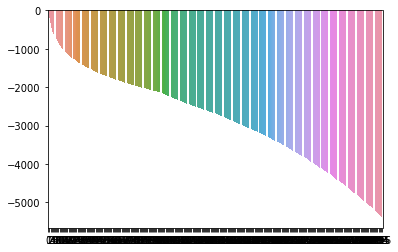

In [249]:
#sns.barplot(list(range(num_population)),
#            [state_values[bucket_state_index(n)] for n in range(num_population)])

sns.barplot(list(range(num_states)),
            [state_values[state_idx] for state_idx in range(num_states)])

In [250]:
state_values.dtype

dtype('float64')

## State Actions

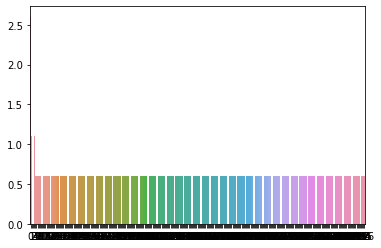

In [254]:
#sns.barplot(list(range(num_population)),
#            [actions[best_action_idx[bucket_state_index(n)]] for n in range(num_population)])

sns.barplot(list(range(num_states)),
            [actions[int(best_action_idx[n])] for n in range(num_states)])

In [255]:
best_action_idx

array([5., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [272]:
# Roll-Out Using Optimal Policy

initial_cases = 100
current_state_idx = bucket_state_index(initial_cases)
total_reward = 0
current_discount = 1

action_history = []
state_history = [current_state_idx]

for i in tqdm(range(100)):
    action_idx = int(best_action_idx[current_state_idx])
    new_state_idx, new_reward = step(current_state_idx, action_idx)
    total_reward += new_reward * current_discount
    
    current_state_idx = new_state_idx
    current_discount *= discount
    
    action_history.append(actions[action_idx])
    state_history.append(states[current_state_idx])

100%|██████████| 100/100 [00:00<00:00, 1368.97it/s]


In [273]:
total_reward

-8364.239389991237

## Case Counts

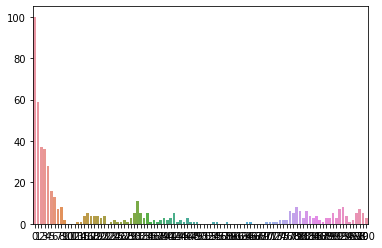

In [274]:
sns.barplot(x=list(range(len(state_history))), y=state_history)

## R(t)

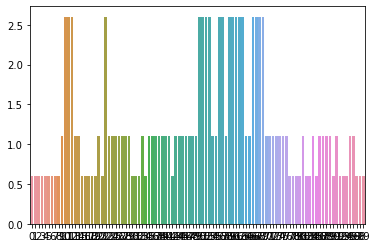

In [275]:
sns.barplot(x=list(range(len(action_history))), y=action_history)